In [2]:
!pip install wordfreq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.6 MB/s eta 0:00:00


In [4]:
!apt-get install -y imagemagick

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts
  imagemagick-6-common imagemagick-6.q16 libdjvulibre-text libdjvulibre21
  libfftw3-double3 libgs9 libgs9-common libidn12 libijs-0.35 libjbig2dec0
  libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6
  libmagickcore-6.q16-6-extra libmagickwand-6.q16-6 libnetpbm10
  libwmflite-0.2-7 netpbm poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  ghostscript-x imagemagick-doc autotrace cups-bsd | lpr | lprng enscript gimp
  gnuplot grads hp2xx html2ps libwmf-bin mplayer povray radiance sane-utils
  texlive-base-bin transfig ufraw-batch libfftw3-bin libfftw3-dev inkscape
  poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fon

In [5]:
import os
import random
import numpy as np
import cv2
import pandas as pd
from pathlib import Path
from subprocess import run

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd
df = pd.DataFrame(columns=["code", "word","language" ,"text_color","background_color", "font_size", "font_family", "font_style", "noise","angle","clean_path","noise_path","binary_mask_path"])

In [8]:

import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageFilter
import random
import io
import os

def to_pil(cv2_img):
    return Image.fromarray(cv2.cvtColor(cv2_img, cv2.COLOR_BGR2RGB))

def to_cv2(pil_img):
    return cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

def apply_noise(image, noise_type):
    if image is None:
        print(f"Warning: Could not read image. Skipping noise type: {noise_type}")
        return None

    pil_img = to_pil(image)
    cv2_img = image.copy()
    h, w = cv2_img.shape[:2]

    if noise_type == "blur":
        return cv2.GaussianBlur(cv2_img, (3, 3), 0)  # reduced from (5,5)

    elif noise_type == "motion blur":
        kernel = np.zeros((9, 9))                   # reduced from (15,15)
        kernel[4, :] = np.ones(9)
        kernel /= 9
        return cv2.filter2D(cv2_img, -1, kernel)

    #chaange denominator for changing its max effect
    elif noise_type == "pixelation":
        h, w = cv2_img.shape[:2]
        temp = cv2.resize(cv2_img, (w//12, h//12), interpolation=cv2.INTER_LINEAR)  # less downscaling
        return cv2.resize(temp, (w, h), interpolation=cv2.INTER_NEAREST)


    elif noise_type == "compression artifacts":
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 10]
        _, enc_img = cv2.imencode('.jpg', cv2_img, encode_param)
        return cv2.imdecode(enc_img, 1)

    elif noise_type == "Gaussian noise":
        row, col, ch = cv2_img.shape
        mean = 0
        sigma = 35
        gauss = np.random.normal(mean, sigma, (row, col, ch))
        gauss = np.clip(gauss, -sigma*3, sigma*3)
        noisy_img = cv2_img.astype(np.float32) + gauss
        noisy_img = np.clip(noisy_img, 0, 255).astype(np.uint8)
        return noisy_img

    elif noise_type == "low resolution":
        small = cv2.resize(cv2_img, (32, 32), interpolation=cv2.INTER_LINEAR)
        return cv2.resize(small, (cv2_img.shape[1], cv2_img.shape[0]), interpolation=cv2.INTER_NEAREST)

    # elif noise_type == "image stretching":
    #     h, w = cv2_img.shape[:2]
    #     return cv2.resize(cv2_img, (int(w * 1.5), h))

    elif noise_type == "defocus blur":
        return cv2.GaussianBlur(cv2_img, (21, 21), 0)

    elif noise_type == "ringing artifacts":
        blurred = cv2.GaussianBlur(cv2_img, (0, 0), 3)
        return cv2.addWeighted(cv2_img, 1.5, blurred, -0.5, 0)

    elif noise_type == "lighting variations":
        enhancer = ImageEnhance.Brightness(pil_img)
        return to_cv2(enhancer.enhance(random.uniform(0.5, 1.5)))

    elif noise_type == "uneven illumination":
        h, w = cv2_img.shape[:2]
        mask = np.zeros((h, w), np.uint8)
        radius = w // 4  # Smaller radius for smaller illuminated area
        cv2.circle(mask, (w // 3, h // 3), radius, 255, -1)
        mask_3_channel = cv2.merge([mask]*3)
        return cv2.addWeighted(cv2_img, 1, mask_3_channel, 0.3, 0)


    # elif noise_type == "shadows":
    #     mask = np.zeros_like(cv2_img)
    #     x1 = random.randint(0, w-1)
    #     y1 = random.randint(0, h-1)
    #     x2 = random.randint(0, w-1)
    #     y2 = random.randint(0, h-1)
    #     cv2.rectangle(mask, (min(x1, x2), min(y1, y2)), (max(x1, x2), max(y1, y2)), (0, 0, 0), -1)
    #     return cv2.addWeighted(cv2_img, 1, mask, 0.5, 0)

    # elif noise_type == "reflections":
    #     overlay = np.full_like(cv2_img, 255)
    #     beta_weight = 0.3
    #     return cv2.addWeighted(cv2_img, 1 - beta_weight, overlay, beta_weight, 0)

    elif noise_type == "glare":
        glare = np.zeros_like(cv2_img)
        center = (random.randint(0, w), random.randint(0, h))
        radius = random.randint(50, 100)
        cv2.circle(glare, center, radius, (180, 180, 180), -1)  # Less bright glare
        return cv2.addWeighted(cv2_img, 0.7, glare, 0.3, 0)


    # elif noise_type == "overexposure":
    #     return cv2.convertScaleAbs(cv2_img, alpha=1.5, beta=50)

    elif noise_type == "underexposure":
        return cv2.convertScaleAbs(cv2_img, alpha=0.5, beta=-50)

    # elif noise_type == "background clutter":
    #     noise_bg = np.random.randint(0, 255, cv2_img.shape, dtype='uint8')
    #     return cv2.addWeighted(cv2_img, 0.8, noise_bg, 0.2, 0)

    elif noise_type == "ambient noise":
        ambient = cv2.GaussianBlur(cv2_img, (15, 15), 20)  # Bigger kernel and higher sigma
        return cv2.addWeighted(cv2_img, 0.6, ambient, 0.4, 0)  # More blurred image weight


    elif noise_type == "perspective distortion":
        pts1 = np.float32([[0,0], [w,0], [0,h], [w,h]])
        pts2 = np.float32([[random.randint(0, w//10), random.randint(0, h//10)],
                           [w-random.randint(0, w//10), random.randint(0, h//10)],
                           [random.randint(0, w//10), h-random.randint(0, h//10)],
                           [w-random.randint(0, w//10), h-random.randint(0, h//10)]])
        M = cv2.getPerspectiveTransform(pts1, pts2)
        return cv2.warpPerspective(cv2_img, M, (w, h))

    elif noise_type == "fading":
        alpha = np.linspace(1, 0.05, w)
        mask = np.tile(alpha, (h, 1))
        return (cv2_img * mask[:, :, np.newaxis]).astype(np.uint8)

    elif noise_type == "ink bleed-through":
        flipped = cv2.flip(cv2_img, 1)
        blended = cv2.addWeighted(cv2_img, 0.8, flipped, 0.2, 0)
        return blended

    elif noise_type == "text smearing":
        kernel = np.ones((1, 6), np.uint8)
        return cv2.dilate(cv2_img, kernel, iterations=2)  # 2 iterations with smaller kernel = moderate effect

    elif noise_type == "stroke breaks":
        # Create a mask with mostly 1s and few 0s to reduce stroke break intensity
        prob = 0.92  # 95% chance of keeping pixels, 5% break
        mask = (np.random.rand(h, w, 1) < prob).astype(np.uint8)
        mask_3_channel = cv2.merge([mask[:, :, 0]] * 3)
        return cv2_img * mask_3_channel

    elif noise_type == "partial occlusion":
        noisy_img = cv2_img.copy()
        for _ in range(2):
            x1, y1 = random.randint(0, max(0, w-50)), random.randint(0, max(0, h-50))
            x2, y2 = x1 + random.randint(20, 35), y1 + random.randint(20, 35)
            cv2.rectangle(noisy_img, (x1, y1), (x2, y2), (0, 0, 0), -1)
        return noisy_img

    # change from 2,2 to 3,3
    elif noise_type == "font erosion":
      kernel = np.ones((3, 3), np.uint8)  # Bigger kernel for stronger erosion
      return cv2.erode(cv2_img, kernel, iterations=2)  # More aggressive


    elif noise_type == "character merging":
        # Choose between min and max effect kernels
        kernels = [np.ones((2, 2), np.uint8), np.ones((3, 3), np.uint8)]
        iterations_options = [1, 2]

        kernel = random.choice(kernels)
        iterations = random.choice(iterations_options)

        # To increase min effect and decrease max effect, limit the max to (3,3) kernel and 2 iterations
        return cv2.dilate(cv2_img, kernel, iterations=iterations)

    elif noise_type == "JPEG compression":
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 5]
        _, enc_img = cv2.imencode('.jpg', cv2_img, encode_param)
        decoded_img = cv2.imdecode(enc_img, cv2.IMREAD_COLOR)
        return decoded_img if decoded_img is not None else cv2_img

    elif noise_type == "color space mismatch":
        return cv2.cvtColor(cv2_img, cv2.COLOR_BGR2HSV)

    elif noise_type == "resolution scaling":
        small = cv2.resize(cv2_img, (w//2, h//2), interpolation=cv2.INTER_LINEAR)
        return cv2.resize(small, (w, h), interpolation=cv2.INTER_NEAREST)

    # elif noise_type == "quantization noise":
    #     levels = 16
    #     return (cv2_img // levels * levels).astype(np.uint8)
    # changed from 1/4 to 1/2 as effect is more

    elif noise_type == "aliasing":
        small = cv2.resize(cv2_img, (w//3, h//3), interpolation=cv2.INTER_LINEAR)
        return cv2.resize(small, (w, h), interpolation=cv2.INTER_NEAREST)
    # chnaged 2  to 3 in denominator
    elif noise_type == "banding":
        banded = cv2_img.copy()
        for i in range(0, h, 20):
            start_row = i
            end_row = min(i + 5, h)
            banded[start_row:end_row] = banded[start_row:end_row] // 3
        return banded

    # elif noise_type == "bit-depth reduction":
    #     return (cv2_img >> 3) << 3

    # elif noise_type == "encoding artifacts":
    #     temp = cv2.cvtColor(cv2_img, cv2.COLOR_BGR2GRAY)
    #     _, binary = cv2.threshold(temp, 127, 255, cv2.THRESH_BINARY)
    #     return cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

    elif noise_type == "scan line artifacts":
        scan_img = cv2_img.copy()
        for i in range(0, h, 5):
             start_row = i
             end_row = min(i + 1, h)
             scan_img[start_row:end_row] = scan_img[start_row:end_row] // 3
        return scan_img
    # increased intensity
    elif noise_type == "scanner streaks":
      streak = cv2_img.copy()
      for _ in range(12):  # More streaks
          x = random.randint(0, w - 3)
          color = [random.randint(0, 255) for _ in range(3)]
          streak[:, x:x+2] = color  # Wider streak (2 px)
      return streak
    # changed
    elif noise_type == "printer toner gaps":
      toner = cv2_img.copy()
      center = h // 2
      for _ in range(3):
          offset = random.randint(-30, 30)  # Gap range near center
          y = np.clip(center + offset, 0, max(0, h - 5))  # Ensure within bounds
          toner[y:y+5, :] = [255, 255, 255]  # White horizontal gap
      return toner


    # elif noise_type == "misaligned scanning":
    #     tx = random.randint(-10, 10)
    #     ty = random.randint(-5, 5)
    #     M = np.float32([[1, 0, tx], [0, 1, ty]])
    #     return cv2.warpAffine(cv2_img, M, (w, h))

    # elif noise_type == "fold marks":
    #     folded = cv2_img.copy()
    #     for _ in range(2):
    #         y = random.randint(0, h-1)
    #         cv2.line(folded, (0, y), (w, y), (200, 200, 200), 2)
    #     return folded

    # changed
    elif noise_type == "paper texture interference":
      noise = np.random.normal(127, 50, cv2_img.shape).astype(np.uint8)  # Higher contrast noise
      return cv2.addWeighted(cv2_img, 0.7, noise, 0.3, 0)  # Stronger blend of noise


    elif noise_type == "multi-layer noise":
        noisy = apply_noise(cv2_img, "Gaussian noise")
        if noisy is not None:
          noisy = apply_noise(noisy, "text smearing")
        if noisy is not None:
          return apply_noise(noisy, "JPEG compression")
        return cv2_img
    # maked it more visible and darker
    elif noise_type == "watermarks":
      font_scale = max(1.5, h / 50)
      thickness = max(2, w // 150)
      watermark = cv2.putText(cv2_img.copy(), "IIT-J", (w // 4, h // 2),
                              cv2.FONT_HERSHEY_SIMPLEX, font_scale, (80, 80, 80), thickness, cv2.LINE_AA)
      return cv2.addWeighted(cv2_img, 0.75, watermark, 0.25, 0)  # Heavier watermark blend


    # elif noise_type == "overlay interference":
    #     overlay = np.full_like(cv2_img, 100)
    #     return cv2.addWeighted(cv2_img, 0.75, overlay, 0.25, 0)

    if noise_type == "salt and pepper":
        prob = 0.01  # Increased from 0.01 to 0.05
        noisy = cv2_img.copy()
        black = np.random.rand(h, w) < prob
        white = np.random.rand(h, w) < prob
        noisy[black] = 0
        noisy[white] = 255
        return noisy

    # increased its wffect
    elif noise_type == "ink spread":
        kernel = np.ones((3, 3), np.uint8)  # Bigger kernel for more spread
        return cv2.dilate(cv2_img, kernel, iterations=1)  # More iterations

    elif noise_type == "horizontal tear":
        y = random.randint(h // 3, 2 * h // 3)
        cv2.line(cv2_img, (0, y), (w, y), (255, 255, 255), thickness=7)
        return cv2_img

    elif noise_type == "vertical tear":
        x = random.randint(w // 3, 2 * w // 3)
        cv2.line(cv2_img, (x, 0), (x, h), (255, 255, 255), thickness=7)
        return cv2_img

    elif noise_type == "smudge":
        smudge_kernel = (9, 9)
        smudged = cv2.blur(cv2_img, smudge_kernel)
        return cv2.addWeighted(cv2_img, 0.6, smudged, 0.4, 0)

    elif noise_type == "text ghosting":
        shifted = np.roll(cv2_img, 5, axis=1)
        return cv2.addWeighted(cv2_img, 0.7, shifted, 0.3, 0)

    elif noise_type == "double scan":
        shifted = np.roll(cv2_img, random.randint(2, 6), axis=0)
        return cv2.addWeighted(cv2_img, 0.5, shifted, 0.5, 0)

    elif noise_type == "wave distortion":
        distorted = np.zeros_like(cv2_img)
        for i in range(h):
            offset = int(10.0 * np.sin(2 * np.pi * i / 60))
            distorted[i] = np.roll(cv2_img[i], offset, axis=1)
        return distorted

    # elif noise_type == "chromatic aberration":
    #     b, g, r = cv2.split(cv2_img)
    #     b = np.roll(b, 1, axis=1)
    #     r = np.roll(r, -1, axis=1)
    #     return cv2.merge([b, g, r])

    elif noise_type == "paper curl":
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.rectangle(mask, (0, 0), (w, h), 255, thickness=30)
        darken = cv2.merge([mask // 3] * 3)
        return cv2.subtract(cv2_img, darken)

    elif noise_type == "random scratches":
        scratched = cv2_img.copy()
        h, w = scratched.shape[:2]
        for _ in range(random.randint(3, 8)):
            x1 = random.randint(0, w)
            y1 = random.randint(0, h)
            x2 = x1 + random.randint(-w//2, w//2)
            y2 = y1 + random.randint(-h//2, h//2)
            color = (255, 255, 255) if random.random() < 0.5 else (0, 0, 0)
            thickness = random.randint(1, 2)
            cv2.line(scratched, (x1, y1), (x2, y2), color, thickness)
        return scratched

    elif noise_type == "scribble":
        scribbled = cv2_img.copy()
        h, w = scribbled.shape[:2]
        for _ in range(random.randint(1, 3)):
            points = np.array([
                [random.randint(0, w), random.randint(0, h)]
                for _ in range(random.randint(4, 7))
            ], np.int32).reshape((-1, 1, 2))
            color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
            thickness = random.randint(1, 2)
            cv2.polylines(scribbled, [points], False, color, thickness, cv2.LINE_AA)
        return scribbled

    elif noise_type == "staple holes":
      noisy_img = cv2_img.copy()
      h, w = noisy_img.shape[:2]

      num_holes = random.randint(1, 4)
      radius = random.randint(5, 10)

      for _ in range(num_holes):
          position = random.choice([
              (random.randint(0, w//10), random.randint(0, h//10)),                  # top-left
              (random.randint(0, w//10), random.randint(h*9//10, h - 1)),            # bottom-left
              (random.randint(w*9//10, w - 1), random.randint(0, h//10)),            # top-right
              (random.randint(w*9//10, w - 1), random.randint(h*9//10, h - 1)),      # bottom-right
              (random.randint(0, w//10), random.randint(h//3, h*2//3)),              # middle-left
              (random.randint(w*9//10, w - 1), random.randint(h//3, h*2//3))         # middle-right
          ])
          cv2.circle(noisy_img, position, radius, (0, 0, 0), -1)

      return noisy_img
    elif noise_type == "water damage":
      h, w = image.shape[:2]
      blurred = cv2.blur(image, (6, 6))
      mask = np.zeros((h, w), dtype=np.uint8)

      num_spots = 2  # Number of damage spots
      for _ in range(num_spots):
          center = (random.randint(0, w), random.randint(0, h))
          radius = random.randint(30, 60)
          cv2.circle(mask, center, radius, 255, -1)

      mask_3ch = cv2.merge([mask]*3)
      return np.where(mask_3ch == 255, blurred, image)

    elif noise_type == "angled line":
      h, w = image.shape[:2]
      noisy_img = image.copy()

      color = (255, 255, 255) if random.random() > 0.5 else (0, 0, 0)
      thickness = 10

      angle = random.uniform(0, 180)
      radians = np.deg2rad(angle)

      # Compute line endpoints so it crosses the image fully
      x0 = int(w / 2 - w * np.cos(radians))
      y0 = int(h / 2 - w * np.sin(radians))
      x1 = int(w / 2 + w * np.cos(radians))
      y1 = int(h / 2 + w * np.sin(radians))

      cv2.line(noisy_img, (x0, y0), (x1, y1), color, thickness)

      return noisy_img
    elif noise_type == "random_erasure":
      h, w = image.shape[:2]
      output = image.copy()
      max_rect = 4;
      num_boxes = random.randint(2,4)  # Always at least 3 boxes

      for _ in range(num_boxes):
          x1 = random.randint(0, max(0, w - 10))
          y1 = random.randint(0, max(0, h - 10))

          box_width = random.randint(7, max(8, w // 5))
          box_height = random.randint(5, max(6, h // 4))

          x2 = min(w, x1 + box_width)
          y2 = min(h, y1 + box_height)

          # Randomly choose color: black or white
          color = 0 if random.random() < 0.5 else 255
          output[y1:y2, x1:x2] = color

      return output

    else:
        return cv2_img

In [9]:
implemented_noise_types = [
    "blur", "motion blur", "pixelation", "compression artifacts", "Gaussian noise",
    "low resolution",  "defocus blur", "uneven illumination",
    "glare", "underexposure", "ambient noise",
    "perspective distortion", "fading", "ink bleed-through", "text smearing",
    "stroke breaks", "partial occlusion", "character merging",
    "JPEG compression", "color space mismatch", "resolution scaling",
    "aliasing", "banding", "scan line artifacts", "scanner streaks",
    "printer toner gaps", "paper texture interference", "multi-layer noise", "watermarks",
    "salt and pepper", "ink spread", "horizontal tear", "vertical tear",
    "smudge", "text ghosting", "double scan", "wave distortion", "paper curl"
]
type1 = [
    "partial occlusion",
    "horizontal tear",
    "vertical tear",
    "scanner streaks",
    "printer toner gaps",
    "smudge",
    "stroke breaks",
    # "cutout",
    "double scan",
    "scribble",
    "random scratches",
    "staple holes",
    "water damage",
    "random_erasure",
    "angled line"
]
type2 = [
    "",
    "perspective distortion",
    # "fading",
    "text ghosting",
    "wave distortion",
    "paper curl",
    # "multi-layer noise"
    "watermarks",
    "ink bleed-through",
    "color space mismatch",
    "resolution scaling"
] #nore about transformations
type3 = [
    "",
    "blur",
    # "motion blur",
    # "pixelation",
    "compression artifacts",
    "Gaussian noise",
    # "low resolution",
    # "defocus blur",
    "uneven illumination",
    "glare",
    # "underexposure",
    "ambient noise",
    "aliasing",
    "banding",
    "scan line artifacts",
    "paper texture interference",
    "salt and pepper",
    "ink spread",
    "character merging",
    "JPEG compression"
]# basic noises like wheather and real life

In [10]:
def generate_mask(clean_img, noisy_img):
    # Resize noisy image to match clean image dimensions (if needed)
    if clean_img.shape != noisy_img.shape:
        noisy_img = cv2.resize(noisy_img, (clean_img.shape[1], clean_img.shape[0]))
        # If clean_img is color and noisy_img is grayscale, convert noisy_img to color
        if len(clean_img.shape) == 3 and len(noisy_img.shape) == 2:
            noisy_img = cv2.cvtColor(noisy_img, cv2.COLOR_GRAY2BGR)
        elif len(clean_img.shape) == 2 and len(noisy_img.shape) == 3:
            clean_img = cv2.cvtColor(clean_img, cv2.COLOR_GRAY2BGR)

    diff = cv2.absdiff(clean_img, noisy_img)
    gray = cv2.cvtColor(diff, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 25, 255, cv2.THRESH_BINARY)
    return mask

In [11]:
light_colors = [
    "white", "lightgray", "silver", "gainsboro", "whitesmoke", "beige",
    "seashell", "ivory", "lightyellow",  # removed 'lightgoldenrodyellow'
    "lightcyan", "lavender", "honeydew", "mintcream", "aliceblue",
    "mistyrose", "linen", "peachpuff", "palegoldenrod",
    "lightblue", "lightgreen", "powderblue", "skyblue", "paleturquoise"
]
dark_colors = [
    "black", "dimgray", "gray", "slategray", "darkslategray",
    "navy", "darkblue", "midnightblue", "darkgreen", "forestgreen",
    "darkolivegreen", "darkseagreen", "teal", "darkcyan", "maroon",
    "brown", "firebrick", "darkred", "purple", "indigo",
    "saddlebrown", "chocolate", "olive", "steelblue"
    # removed "darkmagenta"
]
import random

def get_text_background_pair():
    if random.random() < 0.5:
        text_color = random.choice(dark_colors)
        background_color = random.choice(light_colors)
    else:
        text_color = random.choice(light_colors)
        background_color = random.choice(dark_colors)
    return text_color, background_color

In [17]:
import subprocess
import os
import random
from pathlib import Path
import cv2
import numpy as np
from PIL import Image
import shutil
output_root = '/content/drive/MyDrive/IITJ_Project/English_dataset'
def generate_text_image(
    text: str,
    font_path: str,
    font_size: int,
    output_path: str,
    text_color="black",
    background_color="white",
    rotate_prob=0.3,
    angle=(-30, 30)  # degrees
):
    command = [
        "convert",
        "-background", background_color,
        "-fill", text_color,
        "-font", str(font_path),
        "-pointsize", str(font_size),
        f"label:{text}",
        "-trim",                   # remove extra white space
        "+repage",                 # reset virtual canvas after trim
        "-rotate", str(angle),
        output_path
    ]

    try:
        subprocess.run(command, check=True)
        print(f"Saved clean image: {output_path}")
    except subprocess.CalledProcessError as e:
        print("Failed to generate image:", e)

def generate_and_apply_noise(
    words,
    fonts_dir,
    clean_output_dir,
    noisy_output_dir,
    bitmask_output_dir,
    num_samples=100,
    font_size_range=(32, 128),
    implemented_noise_types=implemented_noise_types,
    rotate_prob=0.3,
    rotate_range=(-100, 100),
    language = "english"
):
    if implemented_noise_types is None:
        implemented_noise_types = [
            "Gaussian noise", "blur", "motion blur", "pixelation"
            # Add your full list here or more implementations in apply_noise()
        ]

    clean_output_dir = Path(clean_output_dir)
    noisy_output_dir = Path(noisy_output_dir)
    bitmask_output_dir = Path(bitmask_output_dir)
    clean_output_dir.mkdir(parents=True, exist_ok=True)
    noisy_output_dir.mkdir(parents=True, exist_ok=True)
    bitmask_output_dir.mkdir(parents=True,exist_ok=True)

    font_families = [f for f in Path(fonts_dir).iterdir() if f.is_dir()]
    if not font_families:
        raise ValueError("No font family folders found.")

    image_counter = 0

    for word in words:
        angle = 0
        if random.random() <= rotate_prob:
          angle = int(round(random.uniform(*rotate_range)))

        random_family = random.choice(font_families)

        fonts = list(random_family.glob("*.ttf")) + list(random_family.glob("*.otf"))
        if not fonts:
            print(f"No fonts found in {random_family}, skipping...")
            continue

        random_font = random.choice(fonts)
        color , background_color = get_text_background_pair()
        font_name = Path(random_font).stem.replace(" ", "_").split('-')[1]
        font_size = random.randint(*font_size_range)


        # File naming for clean image
        clean_filename = f"{image_counter:04d}_{random_family.name}_{font_name}_{color}_{font_size}.png"
        clean_path = clean_output_dir / clean_filename

        # Generate clean synthetic text image
        generate_text_image(
            text=word,
            font_path=random_font,
            font_size=font_size,
            output_path=str(clean_path),
            text_color=color,
            background_color=background_color,
            rotate_prob=0.3,
            angle=angle,
        )

        # Load clean image with OpenCV
        image = cv2.imread(str(clean_path))
        if image is None:
            print(f"Failed to read image {clean_path}, skipping noise application.")
            continue

        # # Choose noise type and apply noise
        # noise_type = random.choice(implemented_noise_types)
        # noisy_image = apply_noise(image, noise_type)

        # # Save noisy image with noise type appended in filename
        # noisy_filename = f"{clean_path.stem}_{noise_type.replace(' ', '_')}.jpg"
        # noisy_path = noisy_output_dir / noisy_filename


        # noisy_img = cv2.imread(str(noisy_path))
        # cv2.imwrite(str(noisy_path), noisy_image)
        # print(f"Saved noisy image: {noisy_path}")
        # # Bitmask filename and path
        # bitmask_filename = f"{clean_path.stem}_{noise_type.replace(' ', '_')}_mask.png"
        # bitmask_path = bitmask_output_dir / bitmask_filename


        # bit_mask_img = generate_mask(image, noisy_image)
        # cv2.imwrite(str(bitmask_path), bit_mask_img)
        # print(f"Saved bitmask image: {bitmask_path}")


        # Apply Type 1 noise (restoration mask-worthy)
        type1_noise = random.choice(type1)
        noisy_img_t1 = apply_noise(image, type1_noise)

        # Generate and save bitmask for Type 1
        bitmask_filename_t1 = f"{clean_path.stem}_{type1_noise.replace(' ', '_')}_mask.png"
        bitmask_path_t1 = bitmask_output_dir / bitmask_filename_t1
        bit_mask_img_t1 = generate_mask(image, noisy_img_t1)
        cv2.imwrite(str(bitmask_path_t1), bit_mask_img_t1)
        print(f"Saved Type1 bitmask: {bitmask_path_t1}")

        # Apply Type 2 noise
        type2_noise = random.choice(type2)
        noisy_img_t2 = apply_noise(noisy_img_t1, type2_noise)

        # Apply Type 3 noise
        type3_noise = random.choice(type3)
        final_noisy = apply_noise(noisy_img_t2, type3_noise)

        # Save final noisy image
        final_filename = f"{clean_path.stem}_{type1_noise}_{type2_noise}_{type3_noise}.jpg".replace(" ", "_")
        noisy_path = noisy_output_dir / final_filename
        cv2.imwrite(str(noisy_path), final_noisy)
        print(f"Saved noisy image: {noisy_path}")

        df.loc[len(df)] = [
            f"{image_counter:04d}",  # code (id)
            word,                   # word (text)
            lang,
            color,                  # text_color
            background_color,
            font_size,              # font_size
            random_family.name,       # font_family
            font_name,              # font_style (font file name)
            f"{type1_noise} + {type2_noise} + {type3_noise}",              # noise applied
            angle,
            clean_path,
            noisy_path,
            bitmask_path_t1
        ]

        image_counter += 1

In [14]:
from wordfreq import top_n_list

all_words = top_n_list('hi', 1000000)

filtered_words = [word for word in all_words if len(word) > 5]

hindi_words = filtered_words[1000:1100]
print(hindi_words)

['रिश्तों', 'विरासत', 'व्यायाम', 'सदस्यता', 'सदियों', 'हाईकोर्ट', 'हालाँकि', 'अनुरूप', 'उत्तरी', 'कामयाब', 'गिरफ्तारी', 'जबरदस्त', 'तथ्यों', 'नामांकन', 'निकाले', 'निरीक्षण', 'पुत्री', 'बलिदान', 'बीकानेर', 'मांगने', 'मिलियन', 'मिसाइल', 'वस्तुओं', 'वार्षिक', 'शनिवार', 'समृद्धि', 'सर्विस', 'सांसदों', 'स्तरीय', 'हड़ताल', 'हिन्दु', 'language', 'system', 'अध्यापक', 'उदयपुर', 'गायत्री', 'जस्टिस', 'जूनियर', 'ज्योतिष', 'त्योहार', 'दिखाना', 'निभाने', 'परिभाषा', 'प्रावधान', 'फैलाने', 'राजनाथ', 'लगेंगे', 'विस्फोट', 'शिक्षित', 'संस्थापक', 'सूत्रों', 'स्टूडियो', 'अर्थात्', 'आतंकवादियों', 'आमंत्रित', 'उज्जैन', 'करूंगा', 'कलाकारों', 'ग्वालियर', 'दर्शाता', 'दुबारा', 'धर्मों', 'नदियों', 'प्यारा', 'बनेंगे', 'भास्कर', 'माध्यमिक', 'मानवता', 'मिश्रण', 'मूल्यों', 'लोकप्रियता', 'शिक्षण', 'संवैधानिक', 'सम्राट', 'सुविधाएं', 'हंगामा', 'हिंदुओं', 'अत्याचार', 'चौकीदार', 'तमन्ना', 'दिसम्बर', 'देवनागरी', 'निर्देशन', 'परिस्थिति', 'प्रबंध', 'प्रोटीन', 'भागीदारी', 'भारतवर्ष', 'मारपीट', 'मिटाने', 'रामदेव', 'शान्ति', 'श्

In [16]:
from wordfreq import top_n_list
import random

# Step 1: Load and filter English words (length > 5)
all_words = top_n_list('en', 1000000)
filtered_words = [word for word in all_words if len(word) > 5]
random.shuffle(filtered_words)  # Shuffle at the start to randomize selection

# Step 2: Slice unique segments for each type
lower_words = filtered_words[:50000]
upper_words = [word.upper() for word in filtered_words[50000:60000]]
capitalized_words = [word.capitalize() for word in filtered_words[60000:80000]]
mix_base_words = filtered_words[80000:90000]

# Step 3: Create 10k mixed word+number entries
mixed_words = []
for word in mix_base_words:
    number = str(random.randint(10, 9999))
    if random.random() < 0.5:
        mixed_words.append(word + " " + number)
    else:
        mixed_words.append(number + " " + word)

# Step 4: Generate 10k pure numbers
pure_numbers = [str(random.randint(100, 999999)) for _ in range(10000)]

# Step 5: Combine everything
final_dataset = lower_words + upper_words + capitalized_words + mixed_words + pure_numbers
random.shuffle(final_dataset)  # Shuffle the final dataset

# Optional: Check counts
print("Lowercase:", len(lower_words))
print("Uppercase:", len(upper_words))
print("Capitalized:", len(capitalized_words))
print("Mixed words:", len(mixed_words))
print("Pure numbers:", len(pure_numbers))
print("Total:", len(set(final_dataset)))

Lowercase: 50000
Uppercase: 10000
Capitalized: 20000
Mixed words: 10000
Pure numbers: 10060
Total: 100002


In [15]:
from wordfreq import top_n_list

all_words = top_n_list('en', 1000000)

filtered_words = [word for word in all_words if len(word) > 5]

english_words = filtered_words[1000:1100]
print(english_words)

['remove', 'spending', 'supporting', 'terrible', "they'll", 'treated', 'turning', 'afraid', 'border', 'canadian', 'command', 'dating', 'elements', 'ensure', 'environmental', 'filled', 'forest', 'intelligence', 'intended', 'labour', 'powers', 'profit', 'republican', 'soldiers', "women's", 'appearance', 'attorney', 'behavior', 'bodies', 'brothers', 'buildings', 'creating', 'domestic', 'expensive', 'historical', 'honestly', 'launch', 'listed', 'minimum', 'native', 'originally', 'planned', 'suddenly', 'supreme', 'survey', 'update', 'writer', 'yellow', 'younger', 'ancient', 'attacks', 'charges', 'combined', 'communication', 'connected', 'contains', 'download', 'ending', 'exercise', 'express', 'formed', 'girlfriend', 'illegal', 'increasing', 'methods', 'officials', "people's", 'performed', 'planet', 'relationships', 'restaurant', 'scotland', 'selected', 'shared', 'shopping', 'suggested', 'supported', 'surprised', 'taught', 'transport', "weren't", 'accepted', 'adding', 'affairs', 'allows', 'a

In [ ]:
# Set output root folder (Google Drive)
output_root = '/content/drive/MyDrive/IITJ_Project/English_dataset'
languages = ["English","Hindi"]
# Create the three folders inside output_root
clean_dir = os.path.join(output_root, 'clean')
noisy_dir = os.path.join(output_root, 'noisy')
bitmask_dir = os.path.join(output_root, 'bitmask')

os.makedirs(clean_dir, exist_ok=True)
os.makedirs(noisy_dir, exist_ok=True)
os.makedirs(bitmask_dir, exist_ok=True)
generate_and_apply_noise(
    words=final_words,
    fonts_dir="/content/drive/MyDrive/IITJ_Project/English_dataset/font-family",  # your fonts folder
    clean_output_dir=clean_dir,  # output clean images
    noisy_output_dir=noisy_dir,  # output noisy images
    bitmask_output_dir=bitmask_dir,
    num_samples=100,
    font_size_range=(40, 120),
    rotate_prob=0.3,
    rotate_range=(-15, 15)
)
metadata_csv_path = os.path.join(output_root, "metadata.csv")
df = pd.DataFrame(df)
df.to_csv(metadata_csv_path, index=False)

In [18]:
languages = ['English', 'Hindi']
language_words = {
    'English': english_words,
    'Hindi': hindi_words,
    # 'Japanese': japanese_words,
}
for lang in languages:
    output_root = f'/content/drive/MyDrive/IITJ_Project/{lang}_dataset'

    clean_dir = os.path.join(output_root, 'clean')
    noisy_dir = os.path.join(output_root, 'noisy')
    bitmask_dir = os.path.join(output_root, 'bitmask')

    os.makedirs(clean_dir, exist_ok=True)
    os.makedirs(noisy_dir, exist_ok=True)
    os.makedirs(bitmask_dir, exist_ok=True)

    generate_and_apply_noise(
        words=language_words[lang],  # dict of lang to word list
        fonts_dir=f"/content/drive/MyDrive/IITJ_Project/{lang}_dataset/font-family",
        clean_output_dir=clean_dir,
        noisy_output_dir=noisy_dir,
        bitmask_output_dir=bitmask_dir,
        num_samples=100,
        font_size_range=(40, 120),
        rotate_prob=0.3,
        rotate_range=(-15, 15),
        language = lang
    )

    # Save metadata
    metadata_csv_path = os.path.join(output_root, "metadata.csv")
    pd.DataFrame(df).to_csv(metadata_csv_path, index=False)

Saved clean image: /content/drive/MyDrive/IITJ_Project/English_dataset/clean/0000_Lora_MediumItalic_black_67.png
Saved Type1 bitmask: /content/drive/MyDrive/IITJ_Project/English_dataset/bitmask/0000_Lora_MediumItalic_black_67_scanner_streaks_mask.png
Saved noisy image: /content/drive/MyDrive/IITJ_Project/English_dataset/noisy/0000_Lora_MediumItalic_black_67_scanner_streaks_paper_curl_JPEG_compression.jpg
Saved clean image: /content/drive/MyDrive/IITJ_Project/English_dataset/clean/0001_Arvo_BoldItalic_darkolivegreen_103.png
Saved Type1 bitmask: /content/drive/MyDrive/IITJ_Project/English_dataset/bitmask/0001_Arvo_BoldItalic_darkolivegreen_103_vertical_tear_mask.png
Saved noisy image: /content/drive/MyDrive/IITJ_Project/English_dataset/noisy/0001_Arvo_BoldItalic_darkolivegreen_103_vertical_tear_watermarks_ink_spread.jpg
Saved clean image: /content/drive/MyDrive/IITJ_Project/English_dataset/clean/0002_Montserrat_Alternates_Regular_lightgreen_77.png
Saved Type1 bitmask: /content/drive/MyDr

KeyboardInterrupt: 

In [19]:
df

,code,word,language,text_color,background_color,font_size,font_family,font_style,noise,angle,clean_path,noise_path,binary_mask_path
0,0000,remove,English,black,powderblue,67,Lora,MediumItalic,scanner streaks + paper curl + JPEG compression,0,/content/drive/MyDrive/IITJ_Project/English_da...,/content/drive/MyDrive/IITJ_Project/English_da...,/content/drive/MyDrive/IITJ_Project/English_da...
1,0001,spending,English,darkolivegreen,lavender,103,Arvo,BoldItalic,vertical tear + watermarks + ink spread,0,/content/drive/MyDrive/IITJ_Project/English_da...,/content/drive/MyDrive/IITJ_Project/English_da...,/content/drive/MyDrive/IITJ_Project/English_da...
2,0002,supporting,English,lightgreen,firebrick,77,Montserrat_Alternates,Regular,scanner streaks + ink bleed-through + compress...,0,/content/drive/MyDrive/IITJ_Project/English_da...,/content/drive/MyDrive/IITJ_Project/English_da...,/content/drive/MyDrive/IITJ_Project/English_da...
3,0003,terrible,English,lavender,navy,40,Arvo,Italic,staple holes + paper curl + compression artifacts,0,/content/drive/MyDrive/IITJ_Project/English_da...,/content/drive/MyDrive/IITJ_Project/English_da...,/content/drive/MyDrive/IITJ_Project/English_da...
4,0004,they'll,English,powderblue,darkcyan,87,Pacifico,Regular,scribble + resolution scaling +,3,/content/drive/MyDrive/IITJ_Project/English_da...,/content/drive/MyDrive/IITJ_Project/English_da...,/content/drive/MyDrive/IITJ_Project/English_da...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,0037,जूनियर,Hindi,honeydew,teal,68,Tiro_Devanagari_Hindi,Italic,scribble + watermarks + paper texture interfer...,-5,/content/drive/MyDrive/IITJ_Project/Hindi_data...,/content/drive/MyDrive/IITJ_Project/Hindi_data...,/content/drive/MyDrive/IITJ_Project/Hindi_data...
138,0038,ज्योतिष,Hindi,darkseagreen,mistyrose,58,Palanquin_Dark,Regular,scribble + text ghosting + ambient noise,0,/content/drive/MyDrive/IITJ_Project/Hindi_data...,/content/drive/MyDrive/IITJ_Project/Hindi_data...,/content/drive/MyDrive/IITJ_Project/Hindi_data...
139,0039,त्योहार,Hindi,lavender,darkgreen,119,Noto_Sans_Devanagari,ExtraBold,partial occlusion + watermarks + salt and pepper,0,/content/drive/MyDrive/IITJ_Project/Hindi_data...,/content/drive/MyDrive/IITJ_Project/Hindi_data...,/content/drive/MyDrive/IITJ_Project/Hindi_data...
140,0040,दिखाना,Hindi,purple,peachpuff,96,Tiro_Devanagari_Hindi,Italic,partial occlusion + color space mismatch + blur,0,/content/drive/MyDrive/IITJ_Project/Hindi_data...,/content/drive/MyDrive/IITJ_Project/Hindi_data...,/content/drive/MyDrive/IITJ_Project/Hindi_data...


In [ ]:
image = cv2.imread("your_image_path.jpg")

In [ ]:
noise = apply_noise(image,"angled line")

array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]], dtype=uint8)
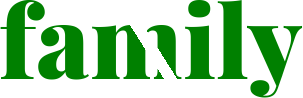

In [ ]:
noise

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)
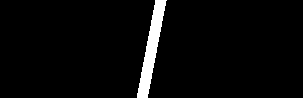

In [ ]:
generate_mask(image,noise)

In [ ]:
from collections import Counter
from indicnlp.tokenize.indic_tokenize import trivial_tokenize

with open('hindi_corpus.txt', encoding='utf-8') as f:
    text = f.read()

tokens = trivial_tokenize(text)
freq = Counter(tokens)

FileNotFoundError: [Errno 2] No such file or directory: 'hindi_corpus.txt'

In [ ]:
# Install the library
!pip install git+https://github.com/anoopkunchukuttan/indic_nlp_library.git

# Clone the resources (once)
!git clone https://github.com/anoopkunchukuttan/indic_nlp_resources.git


  Cloning https://github.com/anoopkunchukuttan/indic_nlp_library.git to /tmp/pip-req-build-74v6wo4h
  Running command git clone --filter=blob:none --quiet https://github.com/anoopkunchukuttan/indic_nlp_library.git /tmp/pip-req-build-74v6wo4h
  Resolved https://github.com/anoopkunchukuttan/indic_nlp_library.git to commit 4cead0ae6c78fe9a19a51ef679f586206df9c476
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 8.5 MB/s eta 0:00:00
  Created wheel for indic_nlp_library: filename=indic_nlp_library-0.92-py3-none-any.whl size=40778 sha256=f972056972ce218838b2676de810fdbc1fe8aeaa5acde2fcc7538ca617f2de5c
  Stored in directory: /tmp/pip-ephem-wheel-cache-urdenwca/wheels/9d/33/9f/fd8d4f05ff87dbaeb38db46b6f6ac377197491fe174661be96
Successfully built indic_nlp_library
Cloning into 'indic_nlp_resources'...
remote: Enumerating objects: 139, done.
remote: Counting objects: 1

In [ ]:
import sys
from indicnlp import common

INDIC_RESOURCES_PATH = "./indic_nlp_resources"
common.set_resources_path(INDIC_RESOURCES_PATH)


In [ ]:
from indicnlp.tokenize.indic_tokenize import trivial_tokenize

text = "यह एक उदाहरण वाक्य है।"
tokens = trivial_tokenize(text, lang='hi')
print(tokens)

['यह', 'एक', 'उदाहरण', 'वाक्य', 'है', '।']


In [ ]:
pip install janome


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 40.6 MB/s eta 0:00:00


In [ ]:
from janome.tokenizer import Tokenizer

t = Tokenizer()

with open("japanese_corpus.txt", encoding="utf-8") as f:
    text = f.read()

word_list = [token.surface for token in t.tokenize(text)]

print(word_list[:20])

FileNotFoundError: [Errno 2] No such file or directory: 'japanese_corpus.txt'

In [ ]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter, map_coordinates

def elastic_transform(image, alpha=34, sigma=4):
    random_state = np.random.RandomState(None)
    shape = image.shape[:2]

    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y + dy, (-1, 1)), np.reshape(x + dx, (-1, 1))

    warped = map_coordinates(image, indices, order=1, mode='reflect').reshape(shape)
    if len(image.shape) == 3:
        return cv2.merge([warped]*3)
    return warped


In [ ]:
from PIL import Image, ImageDraw, ImageFont
import math

def render_curved_text(text, font_path, radius=300):
    font = ImageFont.truetype(font_path, 32)
    width = int(radius * 2 * math.pi)
    height = 100
    image = Image.new('RGB', (width, height), 'white')
    draw = ImageDraw.Draw(image)

    angle_step = 360 / len(text)
    center_x = width // 2
    center_y = radius

    for i, char in enumerate(text):
        angle = math.radians(i * angle_step - 90)
        x = int(center_x + radius * math.cos(angle))
        y = int(center_y + radius * math.sin(angle))
        draw.text((x, y), char, font=font, fill='black')

    return image


In [ ]:
def add_page_crease(image, thickness=2):
    h, w = image.shape[:2]
    x = w // 2 + np.random.randint(-10, 10)
    crease_color = (200, 200, 200)  # light gray fold line
    crease = cv2.line(image.copy(), (x, 0), (x, h), crease_color, thickness)
    return crease


In [ ]:
elastic_transform(image)

RuntimeError: invalid shape for coordinate array